In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import sys
sys.path.append('/Users/yujunwon/Project/dancify/ai/yujun/complete/')

import angle_calc

%config InlineBackend.figure_format = 'retina'

## 1. Keypoints 추출

In [2]:
with open("../point_sample/sample.json", 'r') as f:
    json_data = json.load(f)
len(json_data)

2

In [3]:
keypoints = angle_calc.get_keypoints(json_data)
keypoints

[[[427.4884955087254, 182.10784436156305, 'left_shoulder'],
  [354.00804615088583, 189.88467244972514, 'right_shoulder'],
  [476.7904280494792, 183.72126482132413, 'left_elbow'],
  [310.6017021259135, 207.26402713522435, 'right_elbow'],
  [485.53463359036107, 225.42944193520182, 'left_wrist'],
  [309.4645691170168, 169.6284822040477, 'right_wrist'],
  [412.6742357738002, 290.6946279163935, 'left_hip'],
  [366.9840610907826, 290.120887133862, 'right_hip'],
  [438.3481010713819, 373.063702729207, 'left_knee'],
  [346.6532861423037, 374.41220400969996, 'right_knee'],
  [464.534584566135, 445.67504014274107, 'left_ankle'],
  [327.39942563710133, 444.54447352585976, 'right_ankle']],
 [[1033.55712890625, 396.931357383728, 'left_shoulder'],
  [914.5813179016113, 399.8884606361389, 'right_shoulder'],
  [1071.6423797607422, 444.61283683776855, 'left_elbow'],
  [858.3004188537598, 446.08630299568176, 'right_elbow'],
  [1010.0262451171875, 481.1010718345642, 'left_wrist'],
  [887.3970222473145, 4

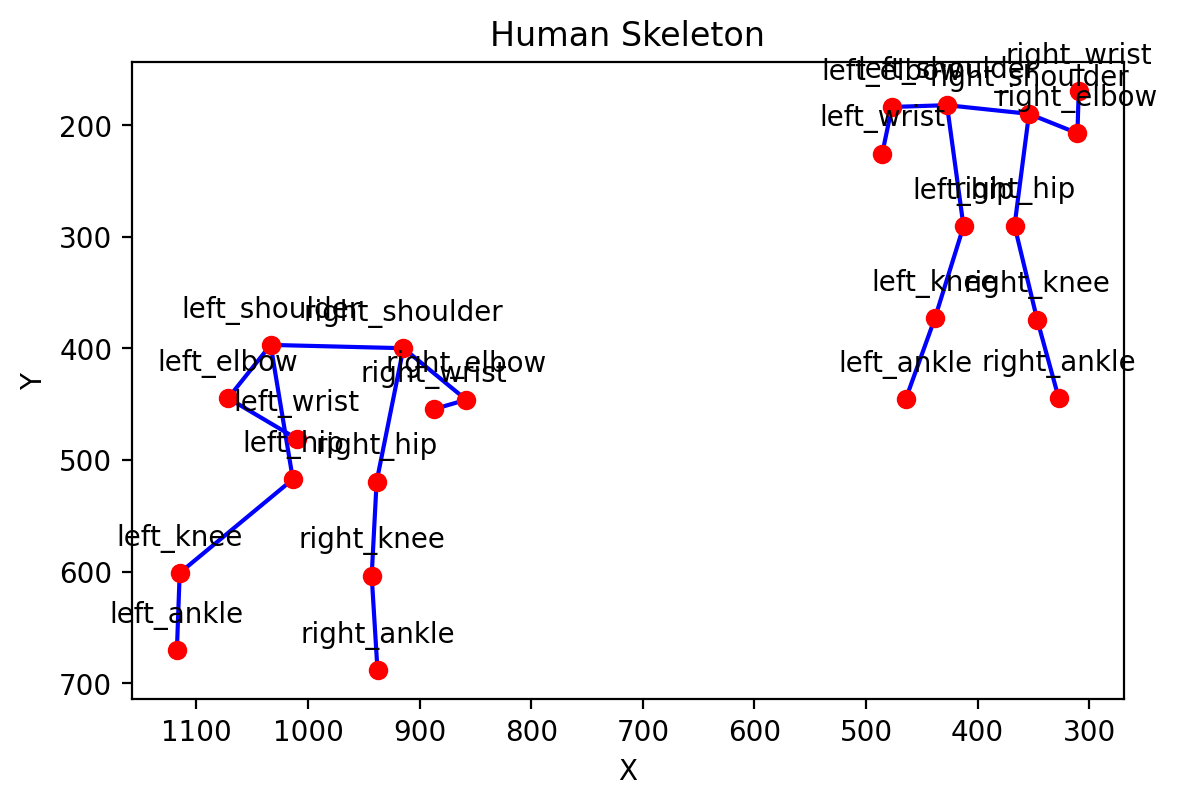

In [4]:
# 인체 뼈대 시각화
connections = [
    [0, 1],         # 어깨
    [0, 2],         # 왼쪽 상박
    [2, 4],         # 왼쪽 하박
    [1, 3],         # 오른쪽 상박
    [3, 5],         # 오른쪽 하박
    [0, 6],         # 왼쪽 허리
    [1, 7],         # 오른쪽 허리
    [6, 8],         # 왼쪽 허벅지
    [7, 9],         # 오른쪽 허벅지
    [8, 10],        # 왼쪽 종아리
    [9, 11]         # 오른쪽 종아리
]

fig, ax = plt.subplots()
ax.set_aspect('equal')

for idx in range(len(keypoints)):
    # 관절 연결하기
    for connection in connections:
        start_idx, end_idx = connection[0], connection[1]
        start_point, end_point = keypoints[idx][start_idx], keypoints[idx][end_idx]
        ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]], 'b')

    # keypoint 찍기
    for keypoint in keypoints[idx]:
        ax.plot(keypoint[0], keypoint[1], 'ro')
        ax.annotate(keypoint[2], (keypoint[0], keypoint[1]), textcoords="offset points", xytext=(0,10), ha='center')

plt.xlabel('X')
plt.ylabel('Y')
ax.invert_yaxis()               # y축 반전
ax.invert_xaxis()               # x축 반전
plt.title('Human Skeleton')
plt.show()

- y가 작은 것이 위로, 큰 것이 아래로 가게 상하반전 되어있음
---

## 2. angle 계산 방법 구현

### 1. 스켈레톤 각각의 arctan2의 차에 대한 절대값을 구하는 방법

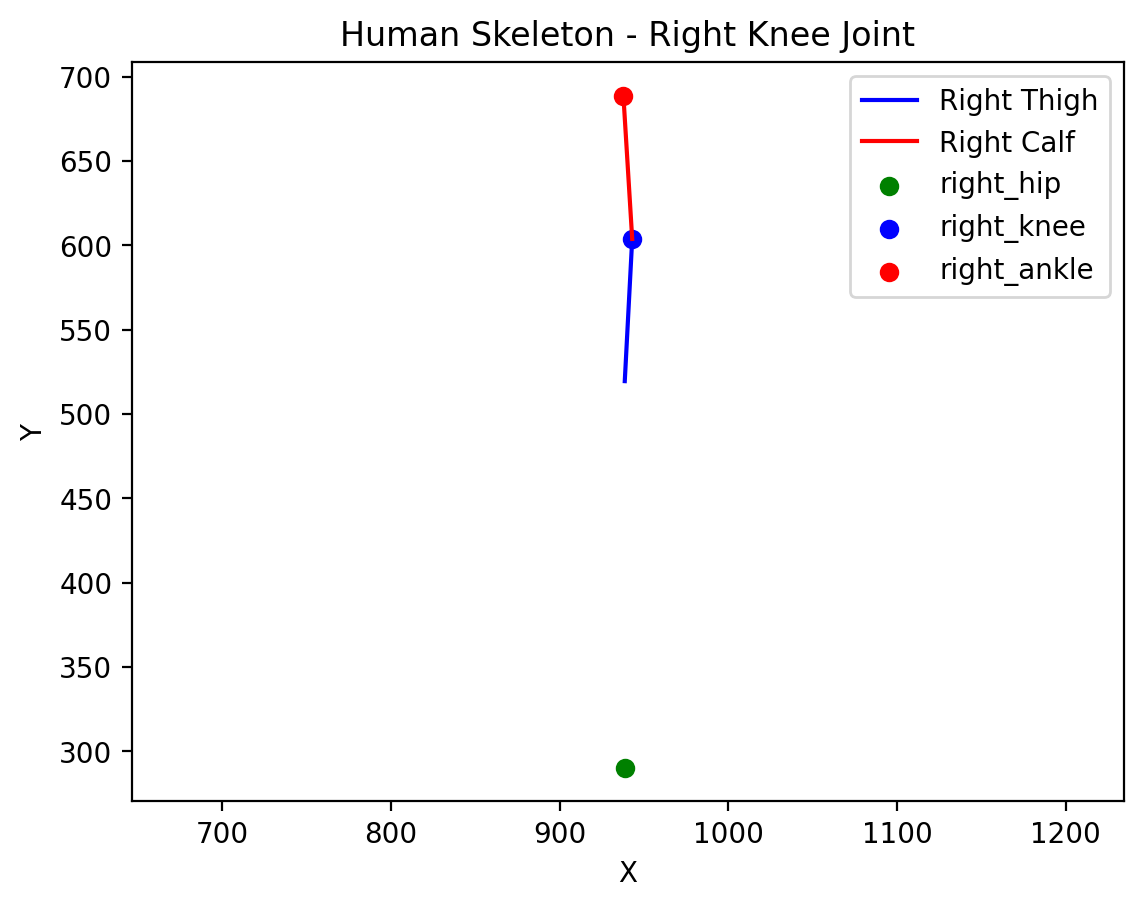

arctan2 차(rad): 0.11371210881338545
arctan2 차(deg): 6.515223914539358
CPU times: user 433 ms, sys: 9.63 ms, total: 443 ms
Wall time: 163 ms


In [6]:
%%time

idx = 1

right_thigh = angle_calc.calculate_angle(keypoints[idx][7][0], keypoints[idx][7][1], keypoints[idx][9][0], keypoints[idx][9][1])
right_calf = angle_calc.calculate_angle(keypoints[idx][9][0], keypoints[idx][9][1], keypoints[idx][11][0], keypoints[idx][11][1])

# 인체 뼈대 시각화
plt.plot([keypoints[idx][7][0], keypoints[idx][9][0]], [keypoints[idx][7][1], keypoints[idx][9][1]], 'b', label='Right Thigh')
plt.plot([keypoints[idx][9][0], keypoints[idx][11][0]], [keypoints[idx][9][1], keypoints[idx][11][1]], 'r', label='Right Calf')
plt.scatter(keypoints[idx][7][0], keypoints[0][7][1], color='g', label='right_hip')
plt.scatter(keypoints[idx][9][0], keypoints[idx][9][1], color='b', label='right_knee')
plt.scatter(keypoints[idx][11][0], keypoints[idx][11][1], color='r', label='right_ankle')
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Human Skeleton - Right Knee Joint')
plt.axis('equal')
plt.show()

print(f"arctan2 차(rad): {abs(right_calf - right_thigh)}")
print(f"arctan2 차(deg): {abs(right_calf - right_thigh) * 180 / np.pi}")

- arctan2의 각을 구하고, 각을 radian에서 degree로 변환
- arctan2의 각은 x축과 해당 스켈레톤이 이루는 각 의미

### 2. 점과 점을 연결하여 벡터를 만들고 두 벡터 사이의 끼인 각을 벡터의 내적을 통해 구하는 방법

In [7]:
%%time

idx = 1

p1 = np.array([keypoints[idx][7][0], keypoints[idx][7][1]])           # 오른쪽 엉덩이
p2 = np.array([keypoints[idx][9][0], keypoints[idx][9][1]])           # 오른쪽 무릎
p3 = np.array([keypoints[idx][11][0], keypoints[idx][11][1]])         # 오른쪽 발

# 벡터 생성
right_thigh = p1 - p2
right_calf = p2 - p3

print(f"오른쪽 허벅지 벡터: {right_thigh}")
print(f"오른쪽 종아리 벡터: {right_calf}") 

# 벡터의 크기
magnitude1 = np.linalg.norm(right_thigh)
magnitude2 = np.linalg.norm(right_calf)

# 내적
dot_product = np.dot(right_thigh, right_calf)

# 각도 계산
angle_rad = np.arccos(dot_product / (magnitude1 * magnitude2))
angle_deg = np.degrees(angle_rad)

print(f"두 벡터 사이의 끼인 각(rad): {angle_rad}")
print(f"두 벡터 사이의 끼인 각(deg): {angle_deg}")

오른쪽 허벅지 벡터: [ -4.41244125 -84.3392086 ]
오른쪽 종아리 벡터: [  5.22062302 -84.86140251]
두 벡터 사이의 끼인 각(rad): 0.1137121088133853
두 벡터 사이의 끼인 각(deg): 6.515223914539349
CPU times: user 253 µs, sys: 48 µs, total: 301 µs
Wall time: 273 µs
